# HW3_2 - Linear Regression

Learning contents:

1. Linear models
    - Polynomial function
    - Radial basis function
    - Sigmoidal basis function
    - Optimization of Error function
    - Test models
2. Bayesian Linear Regression 
    - Generate data
    - Fit the data
    - Predictive distribution

## Dependencies

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from scipy.stats import multivariate_normal

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

In [15]:
def target_func(x): return np.sin(2*np.pi*x)

def generate_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = target_func(x_train) + rng.normal(scale=0.1, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = target_func(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(10)

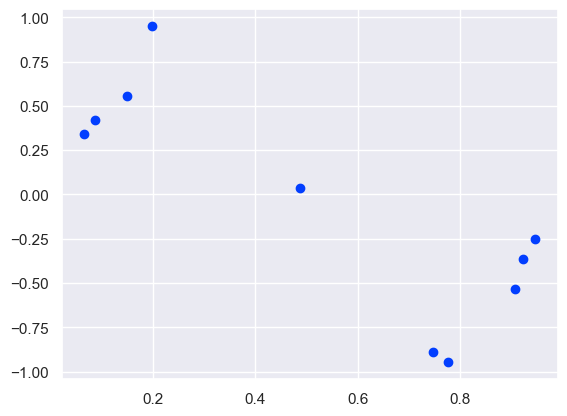

In [16]:
plt.scatter(x_train, y_train)

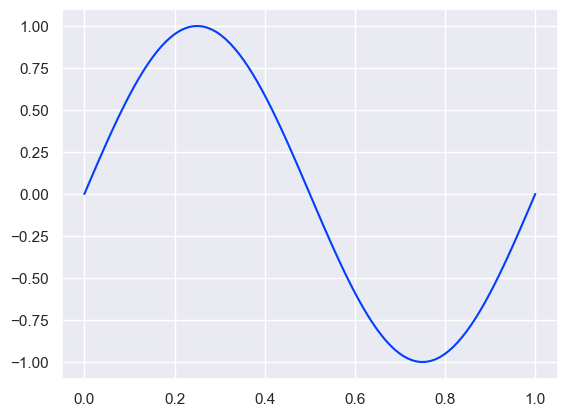

In [17]:
plt.plot(x_test, y_test, '-')

## 1) Linear models

`linear` takes data point `x` (scalar), `basis` function, and `weights` (list|ndarray (M+1)x1) and returns scalar

`basis` function takes `x` (scalar) and `i` (index) and returns `basis_i(x)` (scalar)

In [18]:
def linear(x, basis, weights):
    num_basis = len(weights) - 1  # Number of basis functions
    # Compute the linear combination of the basis functions with the weights
    output = 0
    for i in range(num_basis + 1):
        output += weights[i] * basis(x, i)
    return output

### 1.1) Polynomial basis function

`create_polynomial` returns function that takes `x` (scalar) and `i` (index) and returns the i-th value (scalar) of a polynomial basis function

In [19]:
def create_polynomial():
    def polynomial(x, i):
        return x ** i # the i-th value of the polynomial basis function by raising x to the power of i 
    return polynomial

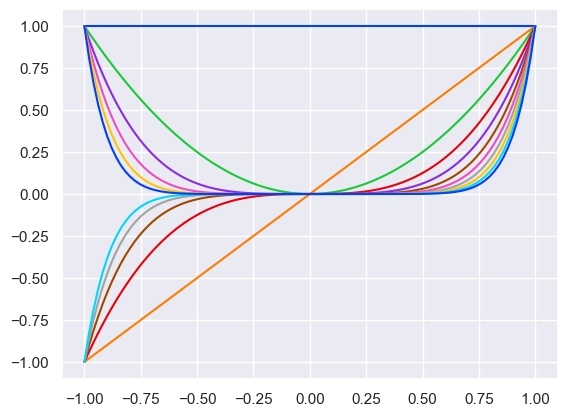

In [20]:
x = np.linspace(-1, 1, 100)
n = 11

polynomial = create_polynomial()

for i in range(n):
    y = list(map(lambda x: polynomial(x, i), x))
    plt.plot(x, y, '-')

### 1.2) Radial basis function

`create_radial` takes `means` and a `variance` as parameters and returns function that takes `x` (scalar) and `i` (index) and returns the i-th value (scalar) of a radial basis function

In [21]:
def create_radial(means, variance):
    def radial(x, i):
        return np.exp(-((x - means[i])**2) / (2 * variance))
# computes the exponential of the squared difference between x and means[i], divided by 2 * variance    
    return radial

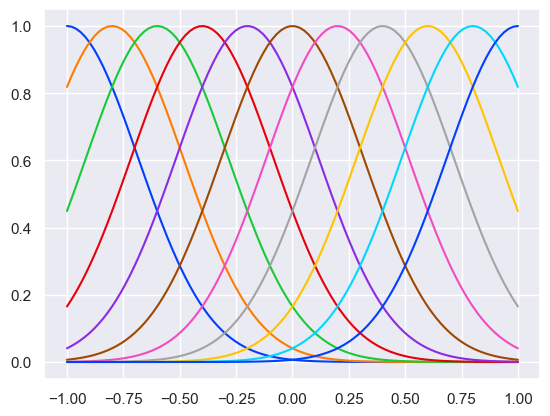

In [22]:
x = np.linspace(-1, 1, 100)
n = 11

radial = create_radial(np.linspace(-1, 1, 11), 0.1)

for i in range(n):
    y = list(map(lambda x: radial(x, i), x))
    plt.plot(x, y, '-')

### 1.3) Sigmoidal basis function

`create_sigmoidal` takes `means` and a coeficient `s` as parameters and returns function that takes `x` (scalar) and `i` (index) and returns the i-th value (scalar) of a sigmoidal basis function

In [23]:
def create_sigmoidal(means, s):
    def sigmoidal(x, i):
        return 1 / (1 + np.exp(-s * (x - means[i])))
    return sigmoidal

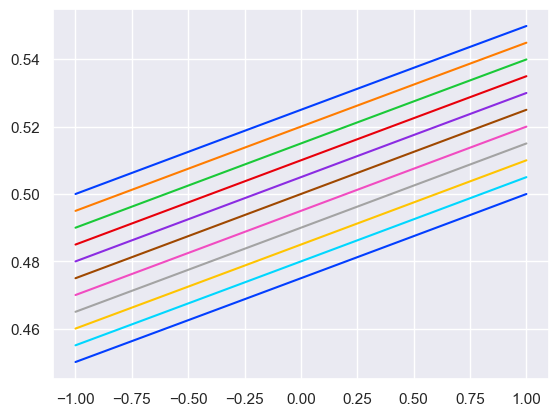

In [24]:
x = np.linspace(-1, 1, 100)
n = 11

sigmoidal = create_sigmoidal(np.linspace(-1, 1, 11), 0.1)

for i in range(n):
    y = list(map(lambda x: sigmoidal(x, i), x))
    plt.plot(x, y, '-')

### 1.4) Optimization of Error function

`optimial_weights` takes `basis` (linear function that takes `x` (scalar) and `i` (index)), `inputs` (list Nx1), `targets` (list Nx1), and `M` (scalar number of weights) as parameters and returns optimal weights (list|ndarray (M+1)x1) for this data and basis function

In [25]:
def optimial_weights(basis, inputs, targets, M):
     # Create the design matrix
    X = np.array([basis(x, i) for x in inputs for i in range(M + 1)]).reshape(-1, M + 1)
    # Compute the optimal weights using least squares
    weights = np.linalg.lstsq(X, targets, rcond=None)[0]
    return weights

### 1.5) Test models

In [26]:
def test(basis, M, label=''):
    plt.plot(x_test, list(map(lambda x: linear(x, basis, optimial_weights(basis, x_train, y_train, M)), x_test)), '-', label=label)
    plt.plot(x_train, y_train, 'og')
    plt.legend()

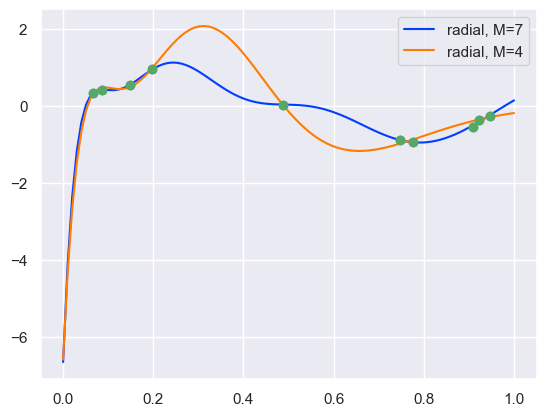

In [27]:
test(create_radial(np.linspace(-1, 1, 10), 0.1), 7, 'radial, M=7')
test(create_radial(np.linspace(-1, 1, 10), 0.1), 4, 'radial, M=4')

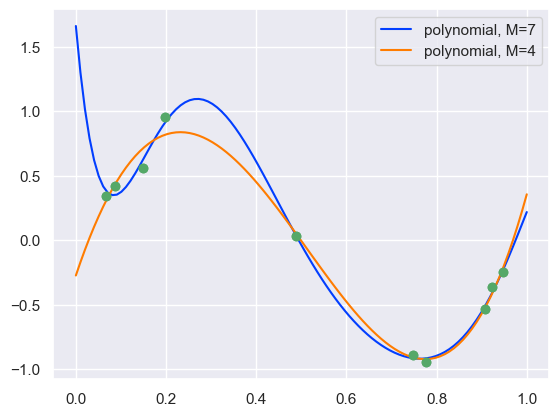

In [28]:
test(create_polynomial(), 7, 'polynomial, M=7')
test(create_polynomial(), 4, 'polynomial, M=4')

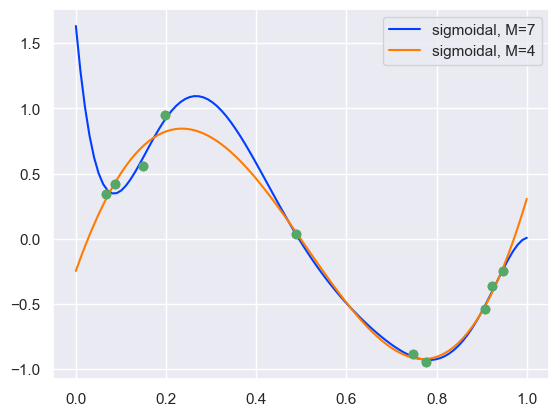

In [29]:
test(create_sigmoidal(np.linspace(0, 1, 8), 1), 7, 'sigmoidal, M=7')
test(create_sigmoidal(np.linspace(0, 1, 8), 1), 4, 'sigmoidal, M=4')

## 2) Bayesian Linear Regression 

### 2.1) Generate data

In [30]:
def line_func(x): return -0.5 + 0.3 * x

def generate_line_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = line_func(x_train) + rng.normal(scale=0.05, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = line_func(x_test)
    
    return x_train, y_train, x_test, y_test

xl_train, yl_train, xl_test, yl_test = generate_line_data(25)

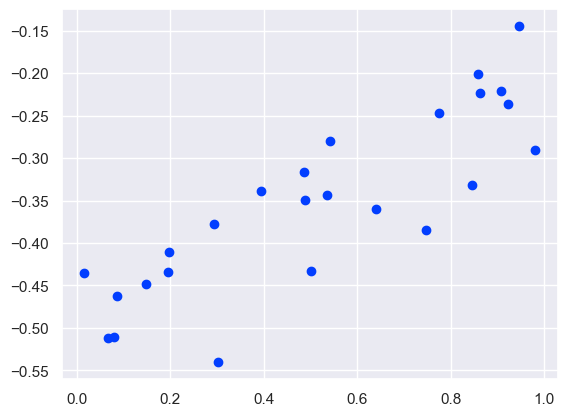

In [31]:
plt.scatter(xl_train, yl_train)

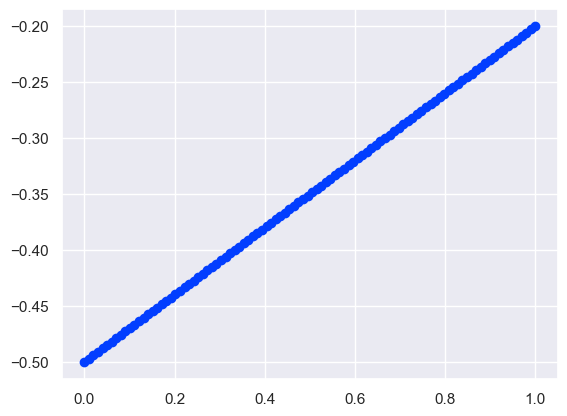

In [32]:
plt.scatter(xl_test, yl_test)

### 2.2) Fit the data

`bayessian_regression_fit` takes `PHI` (ndarray Nx(M+1)), `t` (ndarray Nx1 targets), `alpha` (scalar) and `beta` (scalar) as parameters and must return `mean` (ndarray Mx1) , and `covariance` (ndarray MxM) for the weights

In [35]:
def bayessian_regression_fit(PHI, t, alpha, beta):
    N, M_plus_1 = PHI.shape # PHI is an N x (M + 1) ndarray, N is the number of data points and M is the number of features

    # Compute the covariance matrix of the weights
    alpha_identity = alpha * np.identity(M_plus_1)
    beta_PHI = beta * PHI
    covariance_inv = alpha_identity + np.dot(PHI.T, beta_PHI)
    covariance = np.linalg.inv(covariance_inv)

    # Compute the mean of the weights
    mean = beta * np.dot(covariance, np.dot(PHI.T, t))

    return mean, covariance

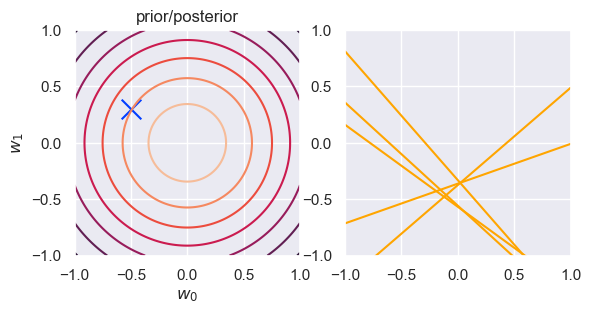

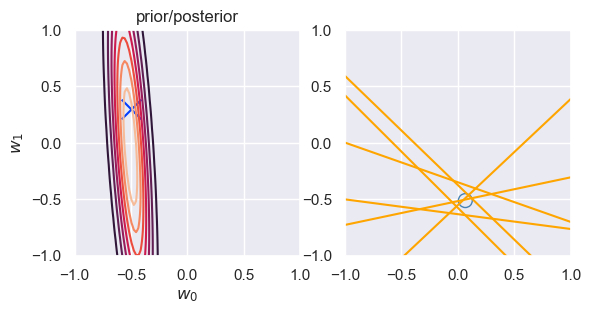

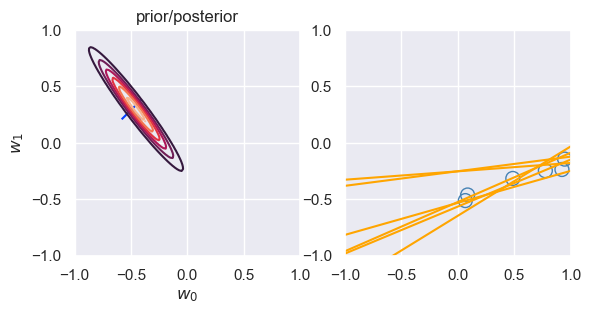

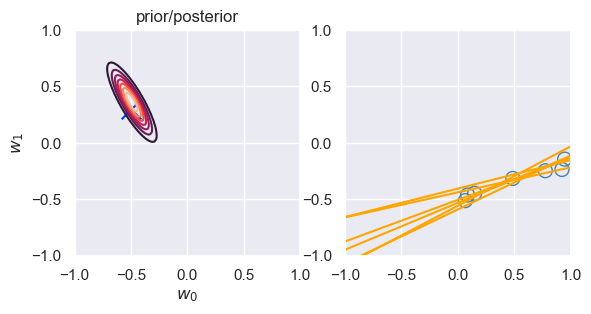

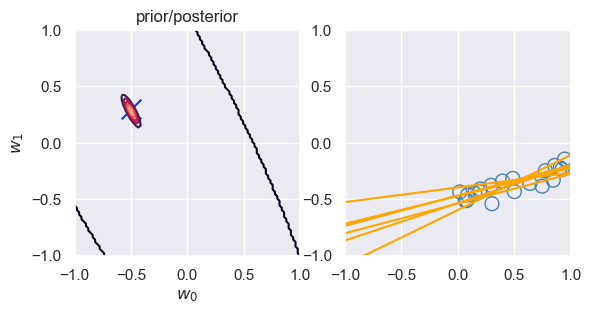

In [36]:
alpha = 1
beta = 100

x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100)
)
w = np.array([w0, w1]).transpose(1, 2, 0)

basis = create_polynomial()

M = 1

PHI = np.array([[basis(x[q], i) for q in range(len(x))] for i in range(M + 1)]).T
PHI_train = np.array([[basis(xl_train[q], i) for q in range(len(xl_train))] for i in range(M + 1)]).T

for begin, end in [[0, 0], [0, 1], [3, 6], [4, 7], [3, 20]]:
    
    w_mean, w_cov = bayessian_regression_fit(PHI_train[begin:end], yl_train[begin:end], alpha, beta)
    
    w_sample = np.random.multivariate_normal(
        w_mean.reshape(-1), w_cov, size=6
    )
    y_sample = PHI @ w_sample.T
    
    
    plt.subplot(1, 2, 1)
    plt.scatter(-0.5, 0.3, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=w_mean, cov=w_cov))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(xl_train[:end], yl_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, y_sample, c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 2.3) Predictive distribution

`sample` takes `PHI_train` (ndarray Nx(M+1)), `y_train` (ndarray Nx1), `alpha` (scalar), `beta` (scalar), and `PHI_test` as parameters and returns `y` (ndarray N_test x 1 prediction means) and `y_std` (ndarray N_test x 1 prediction deviations)

In [37]:
def sample(PHI_train, y_train, alpha, beta, PHI_test):
    N_train, M_plus_1 = PHI_train.shape
    N_test = PHI_test.shape[0]

    # Compute the covariance matrix of the weights
    alpha_identity = alpha * np.identity(M_plus_1)
    beta_PHI_train = beta * PHI_train
    covariance_inv = alpha_identity + np.dot(PHI_train.T, beta_PHI_train)
    covariance = np.linalg.inv(covariance_inv)

    # Compute the mean of the weights
    mean = beta * np.dot(covariance, np.dot(PHI_train.T, y_train))

    # Compute the predictive distribution
    y_mean = np.dot(PHI_test, mean)
    y_var = 1 / beta + np.dot(PHI_test, np.dot(covariance, PHI_test.T))
    y_std = np.sqrt(np.diag(y_var))

    return y_mean, y_std

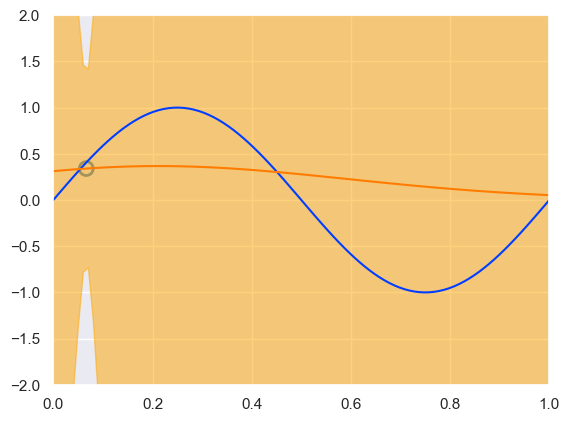

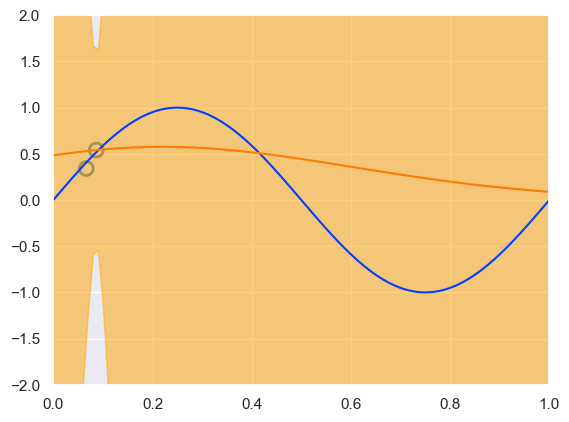

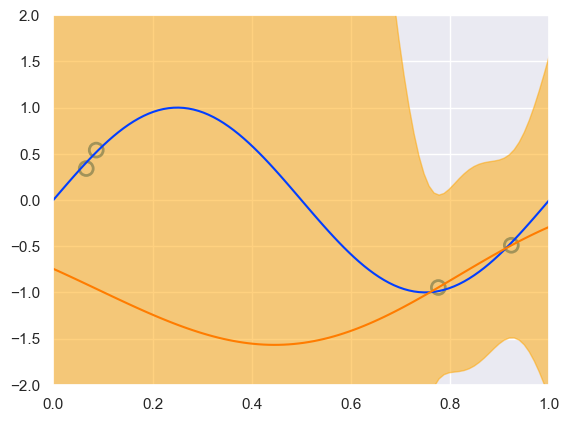

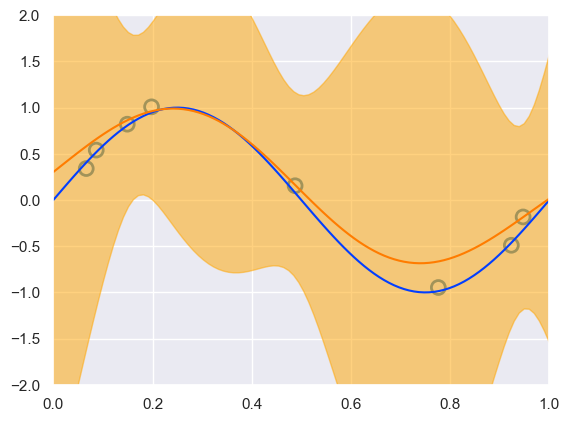

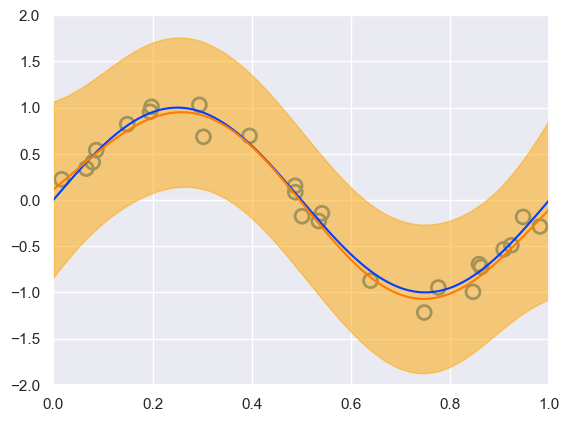

In [38]:
alpha = 1e-3
beta = 2
x_train, y_train, x_test, y_test = generate_data(25)

basis = create_radial(np.linspace(0, 1, 9), 0.1)

M = 8

PHI_train = np.array([[basis(x_train[q], i) for q in range(len(x_train))] for i in range(M + 1)]).T
PHI_test = np.array([[basis(x_test[q], i) for q in range(len(x_test))] for i in range(M + 1)]).T

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    
    y, y_std = sample(PHI_train[begin:end], y_train[begin:end], alpha, beta, PHI_test)
    
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y)
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()